In [1]:
# Download and unzip
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz
!mkdir pixel_data

--2022-11-27 13:40:39--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Translacja www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Łączenie się z www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 170498071 (163M) [application/x-gzip]
Zapis do: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162,60M  4,61MB/s    w 55s      

2022-11-27 13:41:35 (2,94 MB/s) - zapisano ‘cifar-10-python.tar.gz.1’ [170498071/170498071]

mkdir: nie można utworzyć katalogu „pixel_data”: Plik istnieje


In [ ]:
import pickle
import glob
import os

import numpy as np
from skimage.io import imsave


PIXELS_DIR = "pixel_data/"
LABEL_FILE = "labels.txt"


def unpack_file(fname):
    with open(fname, "rb") as f:
        result = pickle.load(f, encoding="bytes")
    return result


def save_as_image(img_flat, fname):
    # consecutive 1024 entries store color channels of 32x32 image
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))

    imsave(os.path.join(PIXELS_DIR, fname), img)

    
labels = {}

# use "data_batch_*" for just the training set
for fname in glob.glob("cifar-10-batches-py/*_batch*"):
    print(fname)
    data = unpack_file(fname)

    for i in range(10000):
        img_flat = data[b"data"][i]
        fname = data[b"filenames"][i].decode()
        label = data[b"labels"][i]

        # save the image and store the label
        save_as_image(img_flat, fname)
        labels[fname] = label

# write out labels file
with open(LABEL_FILE, "w") as f:
    for (fname, label) in labels.items():
        f.write("{0} {1}\n".format(fname, label))

In [3]:
import os

# folder path
# dir_path = 'pixel_data'
dir_path = 'images/val/class/'
# dir_path = 'images/train/class/'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 10000


In [2]:
# Move data into training and validation directories
trainset = 'images/train/class/'
valset = 'images/val/class/'
os.makedirs(trainset, exist_ok=True) #  50,000 images
os.makedirs(valset, exist_ok=True)   #  10,000 images
for i, file in enumerate(os.listdir(PIXELS_DIR)):
  if i < 10000: # first 10000 will be val
    os.rename(PIXELS_DIR + file, valset + file)
  else: # others will be val
    os.rename(PIXELS_DIR + file, trainset + file)

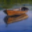

In [4]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename=valset+os.listdir(valset)[0]))

In [5]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [6]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [7]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=10) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [8]:
model = ColorizationNet()

In [9]:
criterion = nn.MSELoss()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [11]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [12]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [13]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [14]:
color_imgs = 'outputs/color/'
gray_imgs = 'outputs/gray/'

In [15]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': gray_imgs, 'colorized': color_imgs}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [17]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [18]:
# Make folders and set parameters
checkpoints = 'checkpoints'
os.makedirs(color_imgs, exist_ok=True)
os.makedirs(gray_imgs, exist_ok=True)
os.makedirs(checkpoints, exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

In [19]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), '{}/model-epoch-{}-losses-{:.3f}.pth'.format(checkpoints,epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/782]	Time 2.113 (2.113)	Data 0.472 (0.472)	Loss 0.7357 (0.7357)	
Epoch: [0][25/782]	Time 1.142 (1.119)	Data 0.670 (0.681)	Loss 0.0092 (0.1566)	
Epoch: [0][50/782]	Time 0.501 (1.066)	Data 0.448 (0.668)	Loss 0.0036 (0.0832)	
Epoch: [0][75/782]	Time 0.514 (0.881)	Data 0.461 (0.597)	Loss 0.0044 (0.0574)	
Epoch: [0][100/782]	Time 0.527 (0.785)	Data 0.475 (0.558)	Loss 0.0060 (0.0444)	
Epoch: [0][125/782]	Time 0.476 (0.727)	Data 0.424 (0.534)	Loss 0.0041 (0.0365)	
Epoch: [0][150/782]	Time 0.463 (0.684)	Data 0.411 (0.515)	Loss 0.0033 (0.0311)	
Epoch: [0][175/782]	Time 0.503 (0.654)	Data 0.452 (0.502)	Loss 0.0033 (0.0272)	
Epoch: [0][200/782]	Time 0.469 (0.631)	Data 0.415 (0.491)	Loss 0.0044 (0.0242)	
Epoch: [0][225/782]	Time 0.489 (0.614)	Data 0.437 (0.484)	Loss 0.0026 (0.0220)	
Epoch: [0][250/782]	Time 0.459 (0.600)	Data 0.407 (0.477)	Loss 0.0030 (0.0201)	
Epoch: [0][275/782]	Time 0.471 (0.588)	Data 0.419 (0.472)	Loss 0.0036 (0.0186)	
Epoch: [0][300/782]

Epoch: [2][650/782]	Time 0.451 (0.471)	Data 0.399 (0.419)	Loss 0.0022 (0.0028)	
Epoch: [2][675/782]	Time 0.457 (0.470)	Data 0.406 (0.418)	Loss 0.0025 (0.0028)	
Epoch: [2][700/782]	Time 0.498 (0.470)	Data 0.444 (0.418)	Loss 0.0057 (0.0028)	
Epoch: [2][725/782]	Time 0.458 (0.470)	Data 0.407 (0.418)	Loss 0.0024 (0.0029)	
Epoch: [2][750/782]	Time 0.488 (0.470)	Data 0.436 (0.418)	Loss 0.0033 (0.0029)	
Epoch: [2][775/782]	Time 0.464 (0.470)	Data 0.411 (0.418)	Loss 0.0033 (0.0029)	
Finished training epoch 2
Validate: [0/157]	Time 0.540 (0.540)	Loss 0.0038 (0.0038)	
Validate: [25/157]	Time 0.456 (0.461)	Loss 0.0022 (0.0034)	
Validate: [50/157]	Time 0.453 (0.461)	Loss 0.0018 (0.0033)	
Validate: [75/157]	Time 0.440 (0.462)	Loss 0.0022 (0.0033)	
Validate: [100/157]	Time 0.475 (0.460)	Loss 0.0028 (0.0032)	
Validate: [125/157]	Time 0.490 (0.461)	Loss 0.0034 (0.0031)	
Validate: [150/157]	Time 0.447 (0.461)	Loss 0.0025 (0.0031)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/782]	Time 0.

Epoch: [5][375/782]	Time 0.474 (0.469)	Data 0.422 (0.417)	Loss 0.0021 (0.0027)	
Epoch: [5][400/782]	Time 0.494 (0.469)	Data 0.444 (0.417)	Loss 0.0026 (0.0027)	
Epoch: [5][425/782]	Time 0.493 (0.469)	Data 0.440 (0.417)	Loss 0.0026 (0.0027)	
Epoch: [5][450/782]	Time 0.470 (0.469)	Data 0.420 (0.417)	Loss 0.0031 (0.0027)	
Epoch: [5][475/782]	Time 0.461 (0.469)	Data 0.410 (0.417)	Loss 0.0029 (0.0027)	
Epoch: [5][500/782]	Time 0.475 (0.469)	Data 0.424 (0.417)	Loss 0.0022 (0.0027)	
Epoch: [5][525/782]	Time 0.456 (0.469)	Data 0.405 (0.417)	Loss 0.0023 (0.0027)	
Epoch: [5][550/782]	Time 0.469 (0.469)	Data 0.417 (0.417)	Loss 0.0026 (0.0027)	
Epoch: [5][575/782]	Time 0.480 (0.469)	Data 0.428 (0.417)	Loss 0.0026 (0.0027)	
Epoch: [5][600/782]	Time 0.461 (0.469)	Data 0.410 (0.417)	Loss 0.0028 (0.0027)	
Epoch: [5][625/782]	Time 0.460 (0.469)	Data 0.408 (0.417)	Loss 0.0022 (0.0027)	
Epoch: [5][650/782]	Time 0.464 (0.469)	Data 0.411 (0.417)	Loss 0.0026 (0.0026)	
Epoch: [5][675/782]	Time 0.531 (0.469)	D

Epoch: [8][100/782]	Time 0.494 (0.472)	Data 0.442 (0.420)	Loss 0.0024 (0.0026)	
Epoch: [8][125/782]	Time 0.471 (0.472)	Data 0.420 (0.420)	Loss 0.0028 (0.0026)	
Epoch: [8][150/782]	Time 0.460 (0.471)	Data 0.407 (0.420)	Loss 0.0020 (0.0025)	
Epoch: [8][175/782]	Time 0.469 (0.471)	Data 0.419 (0.420)	Loss 0.0019 (0.0025)	
Epoch: [8][200/782]	Time 0.459 (0.471)	Data 0.406 (0.420)	Loss 0.0027 (0.0025)	
Epoch: [8][225/782]	Time 0.465 (0.471)	Data 0.414 (0.419)	Loss 0.0021 (0.0025)	
Epoch: [8][250/782]	Time 0.470 (0.470)	Data 0.419 (0.418)	Loss 0.0027 (0.0025)	
Epoch: [8][275/782]	Time 0.532 (0.471)	Data 0.481 (0.419)	Loss 0.0030 (0.0025)	
Epoch: [8][300/782]	Time 0.480 (0.471)	Data 0.428 (0.420)	Loss 0.0025 (0.0025)	
Epoch: [8][325/782]	Time 0.480 (0.471)	Data 0.429 (0.419)	Loss 0.0024 (0.0025)	
Epoch: [8][350/782]	Time 0.465 (0.471)	Data 0.414 (0.419)	Loss 0.0021 (0.0025)	
Epoch: [8][375/782]	Time 0.461 (0.471)	Data 0.410 (0.419)	Loss 0.0024 (0.0025)	
Epoch: [8][400/782]	Time 0.478 (0.471)	D

Epoch: [10][750/782]	Time 0.457 (0.475)	Data 0.406 (0.422)	Loss 0.0036 (0.0024)	
Epoch: [10][775/782]	Time 0.474 (0.475)	Data 0.421 (0.422)	Loss 0.0028 (0.0024)	
Finished training epoch 10
Validate: [0/157]	Time 0.530 (0.530)	Loss 0.0029 (0.0029)	
Validate: [25/157]	Time 0.451 (0.472)	Loss 0.0019 (0.0026)	
Validate: [50/157]	Time 0.458 (0.470)	Loss 0.0015 (0.0025)	
Validate: [75/157]	Time 0.457 (0.467)	Loss 0.0018 (0.0025)	
Validate: [100/157]	Time 0.459 (0.466)	Loss 0.0018 (0.0024)	
Validate: [125/157]	Time 0.466 (0.465)	Loss 0.0026 (0.0024)	
Validate: [150/157]	Time 0.473 (0.465)	Loss 0.0019 (0.0024)	
Finished validation.
Starting training epoch 11
Epoch: [11][0/782]	Time 0.477 (0.477)	Data 0.420 (0.420)	Loss 0.0024 (0.0024)	
Epoch: [11][25/782]	Time 0.470 (0.472)	Data 0.419 (0.420)	Loss 0.0022 (0.0024)	
Epoch: [11][50/782]	Time 0.460 (0.468)	Data 0.408 (0.416)	Loss 0.0027 (0.0024)	
Epoch: [11][75/782]	Time 0.464 (0.470)	Data 0.412 (0.418)	Loss 0.0024 (0.0024)	
Epoch: [11][100/782]	T

Epoch: [13][425/782]	Time 0.470 (0.472)	Data 0.419 (0.420)	Loss 0.0036 (0.0024)	
Epoch: [13][450/782]	Time 0.464 (0.472)	Data 0.412 (0.420)	Loss 0.0031 (0.0024)	
Epoch: [13][475/782]	Time 0.501 (0.472)	Data 0.449 (0.420)	Loss 0.0028 (0.0024)	
Epoch: [13][500/782]	Time 0.463 (0.473)	Data 0.411 (0.421)	Loss 0.0021 (0.0024)	
Epoch: [13][525/782]	Time 0.476 (0.473)	Data 0.425 (0.421)	Loss 0.0035 (0.0024)	
Epoch: [13][550/782]	Time 0.459 (0.473)	Data 0.407 (0.421)	Loss 0.0023 (0.0024)	
Epoch: [13][575/782]	Time 0.470 (0.473)	Data 0.419 (0.420)	Loss 0.0024 (0.0024)	
Epoch: [13][600/782]	Time 0.490 (0.473)	Data 0.436 (0.421)	Loss 0.0021 (0.0024)	
Epoch: [13][625/782]	Time 0.470 (0.473)	Data 0.416 (0.421)	Loss 0.0026 (0.0024)	
Epoch: [13][650/782]	Time 0.467 (0.473)	Data 0.416 (0.421)	Loss 0.0030 (0.0024)	
Epoch: [13][675/782]	Time 0.468 (0.473)	Data 0.416 (0.421)	Loss 0.0029 (0.0024)	
Epoch: [13][700/782]	Time 0.471 (0.474)	Data 0.418 (0.421)	Loss 0.0023 (0.0024)	
Epoch: [13][725/782]	Time 0.

Epoch: [16][100/782]	Time 0.473 (0.475)	Data 0.420 (0.423)	Loss 0.0028 (0.0024)	
Epoch: [16][125/782]	Time 0.462 (0.474)	Data 0.410 (0.422)	Loss 0.0018 (0.0024)	
Epoch: [16][150/782]	Time 0.458 (0.474)	Data 0.406 (0.421)	Loss 0.0030 (0.0024)	
Epoch: [16][175/782]	Time 0.467 (0.473)	Data 0.412 (0.421)	Loss 0.0020 (0.0024)	
Epoch: [16][200/782]	Time 0.483 (0.472)	Data 0.432 (0.420)	Loss 0.0021 (0.0025)	
Epoch: [16][225/782]	Time 0.465 (0.472)	Data 0.414 (0.420)	Loss 0.0028 (0.0025)	
Epoch: [16][250/782]	Time 0.470 (0.472)	Data 0.416 (0.420)	Loss 0.0025 (0.0025)	
Epoch: [16][275/782]	Time 0.484 (0.472)	Data 0.433 (0.420)	Loss 0.0036 (0.0025)	
Epoch: [16][300/782]	Time 0.497 (0.472)	Data 0.445 (0.420)	Loss 0.0024 (0.0025)	
Epoch: [16][325/782]	Time 0.477 (0.472)	Data 0.423 (0.420)	Loss 0.0021 (0.0025)	
Epoch: [16][350/782]	Time 0.507 (0.472)	Data 0.454 (0.420)	Loss 0.0032 (0.0025)	
Epoch: [16][375/782]	Time 0.464 (0.472)	Data 0.413 (0.420)	Loss 0.0022 (0.0025)	
Epoch: [16][400/782]	Time 0.

Epoch: [18][725/782]	Time 0.974 (0.991)	Data 0.584 (0.625)	Loss 0.0024 (0.0024)	
Epoch: [18][750/782]	Time 0.926 (0.991)	Data 0.586 (0.625)	Loss 0.0030 (0.0024)	
Epoch: [18][775/782]	Time 0.920 (0.993)	Data 0.581 (0.626)	Loss 0.0028 (0.0024)	
Finished training epoch 18
Validate: [0/157]	Time 0.802 (0.802)	Loss 0.0025 (0.0025)	
Validate: [25/157]	Time 0.724 (0.769)	Loss 0.0022 (0.0025)	
Validate: [50/157]	Time 0.729 (0.756)	Loss 0.0013 (0.0025)	
Validate: [75/157]	Time 0.732 (0.748)	Loss 0.0016 (0.0025)	
Validate: [100/157]	Time 0.733 (0.745)	Loss 0.0019 (0.0024)	
Validate: [125/157]	Time 0.734 (0.749)	Loss 0.0027 (0.0024)	
Validate: [150/157]	Time 0.730 (0.760)	Loss 0.0017 (0.0023)	
Finished validation.
Starting training epoch 19
Epoch: [19][0/782]	Time 0.756 (0.756)	Data 0.416 (0.416)	Loss 0.0023 (0.0023)	
Epoch: [19][25/782]	Time 0.921 (0.993)	Data 0.579 (0.631)	Loss 0.0022 (0.0024)	
Epoch: [19][50/782]	Time 0.922 (1.017)	Data 0.582 (0.647)	Loss 0.0026 (0.0024)	
Epoch: [19][75/782]	T

Epoch: [21][400/782]	Time 0.483 (0.493)	Data 0.423 (0.438)	Loss 0.0025 (0.0024)	
Epoch: [21][425/782]	Time 0.520 (0.493)	Data 0.462 (0.438)	Loss 0.0020 (0.0024)	
Epoch: [21][450/782]	Time 0.504 (0.494)	Data 0.443 (0.438)	Loss 0.0026 (0.0024)	
Epoch: [21][475/782]	Time 0.473 (0.494)	Data 0.421 (0.438)	Loss 0.0021 (0.0024)	
Epoch: [21][500/782]	Time 0.477 (0.492)	Data 0.424 (0.437)	Loss 0.0026 (0.0024)	
Epoch: [21][525/782]	Time 0.537 (0.492)	Data 0.477 (0.437)	Loss 0.0026 (0.0024)	
Epoch: [21][550/782]	Time 0.502 (0.492)	Data 0.441 (0.437)	Loss 0.0030 (0.0024)	
Epoch: [21][575/782]	Time 0.495 (0.492)	Data 0.436 (0.437)	Loss 0.0022 (0.0024)	
Epoch: [21][600/782]	Time 0.495 (0.493)	Data 0.432 (0.437)	Loss 0.0024 (0.0024)	
Epoch: [21][625/782]	Time 0.468 (0.493)	Data 0.416 (0.437)	Loss 0.0027 (0.0024)	
Epoch: [21][650/782]	Time 0.482 (0.492)	Data 0.428 (0.436)	Loss 0.0023 (0.0024)	
Epoch: [21][675/782]	Time 0.469 (0.491)	Data 0.415 (0.436)	Loss 0.0025 (0.0024)	
Epoch: [21][700/782]	Time 0.

Epoch: [24][75/782]	Time 0.517 (0.477)	Data 0.464 (0.424)	Loss 0.0028 (0.0023)	
Epoch: [24][100/782]	Time 0.493 (0.477)	Data 0.442 (0.424)	Loss 0.0029 (0.0024)	
Epoch: [24][125/782]	Time 0.479 (0.476)	Data 0.428 (0.423)	Loss 0.0025 (0.0024)	
Epoch: [24][150/782]	Time 0.475 (0.475)	Data 0.424 (0.423)	Loss 0.0018 (0.0023)	
Epoch: [24][175/782]	Time 0.484 (0.474)	Data 0.432 (0.422)	Loss 0.0020 (0.0023)	
Epoch: [24][200/782]	Time 0.502 (0.474)	Data 0.450 (0.422)	Loss 0.0024 (0.0023)	
Epoch: [24][225/782]	Time 0.456 (0.474)	Data 0.403 (0.422)	Loss 0.0021 (0.0023)	
Epoch: [24][250/782]	Time 0.472 (0.474)	Data 0.421 (0.422)	Loss 0.0026 (0.0023)	
Epoch: [24][275/782]	Time 0.463 (0.474)	Data 0.411 (0.421)	Loss 0.0023 (0.0023)	
Epoch: [24][300/782]	Time 0.475 (0.474)	Data 0.422 (0.422)	Loss 0.0027 (0.0023)	
Epoch: [24][325/782]	Time 0.456 (0.474)	Data 0.405 (0.422)	Loss 0.0023 (0.0023)	
Epoch: [24][350/782]	Time 0.464 (0.474)	Data 0.412 (0.422)	Loss 0.0019 (0.0023)	
Epoch: [24][375/782]	Time 0.4

Epoch: [26][725/782]	Time 0.471 (0.474)	Data 0.417 (0.422)	Loss 0.0024 (0.0024)	
Epoch: [26][750/782]	Time 0.472 (0.474)	Data 0.420 (0.422)	Loss 0.0024 (0.0024)	
Epoch: [26][775/782]	Time 0.486 (0.474)	Data 0.433 (0.422)	Loss 0.0023 (0.0024)	
Finished training epoch 26
Validate: [0/157]	Time 0.557 (0.557)	Loss 0.0026 (0.0026)	
Validate: [25/157]	Time 0.495 (0.473)	Loss 0.0020 (0.0025)	
Validate: [50/157]	Time 0.455 (0.469)	Loss 0.0015 (0.0024)	
Validate: [75/157]	Time 0.456 (0.468)	Loss 0.0017 (0.0024)	
Validate: [100/157]	Time 0.469 (0.467)	Loss 0.0017 (0.0024)	
Validate: [125/157]	Time 0.456 (0.466)	Loss 0.0025 (0.0023)	
Validate: [150/157]	Time 0.465 (0.465)	Loss 0.0018 (0.0023)	
Finished validation.
Starting training epoch 27
Epoch: [27][0/782]	Time 0.490 (0.490)	Data 0.430 (0.430)	Loss 0.0018 (0.0018)	
Epoch: [27][25/782]	Time 0.508 (0.486)	Data 0.446 (0.432)	Loss 0.0018 (0.0023)	
Epoch: [27][50/782]	Time 0.466 (0.479)	Data 0.415 (0.425)	Loss 0.0023 (0.0023)	
Epoch: [27][75/782]	T

Epoch: [29][400/782]	Time 0.485 (0.489)	Data 0.434 (0.433)	Loss 0.0023 (0.0023)	
Epoch: [29][425/782]	Time 0.512 (0.489)	Data 0.452 (0.433)	Loss 0.0018 (0.0023)	
Epoch: [29][450/782]	Time 0.473 (0.489)	Data 0.420 (0.433)	Loss 0.0021 (0.0023)	
Epoch: [29][475/782]	Time 0.481 (0.488)	Data 0.429 (0.433)	Loss 0.0027 (0.0023)	
Epoch: [29][500/782]	Time 0.493 (0.488)	Data 0.436 (0.433)	Loss 0.0023 (0.0023)	
Epoch: [29][525/782]	Time 0.488 (0.488)	Data 0.432 (0.433)	Loss 0.0021 (0.0023)	
Epoch: [29][550/782]	Time 0.478 (0.488)	Data 0.425 (0.432)	Loss 0.0020 (0.0023)	
Epoch: [29][575/782]	Time 0.475 (0.488)	Data 0.424 (0.432)	Loss 0.0024 (0.0023)	
Epoch: [29][600/782]	Time 0.478 (0.487)	Data 0.418 (0.432)	Loss 0.0025 (0.0023)	
Epoch: [29][625/782]	Time 0.491 (0.487)	Data 0.438 (0.432)	Loss 0.0020 (0.0023)	
Epoch: [29][650/782]	Time 0.499 (0.487)	Data 0.439 (0.432)	Loss 0.0018 (0.0023)	
Epoch: [29][675/782]	Time 0.518 (0.487)	Data 0.459 (0.432)	Loss 0.0022 (0.0023)	
Epoch: [29][700/782]	Time 0.

Epoch: [32][75/782]	Time 0.466 (0.472)	Data 0.414 (0.419)	Loss 0.0020 (0.0023)	
Epoch: [32][100/782]	Time 0.479 (0.474)	Data 0.426 (0.421)	Loss 0.0019 (0.0023)	
Epoch: [32][125/782]	Time 0.464 (0.474)	Data 0.412 (0.421)	Loss 0.0027 (0.0023)	
Epoch: [32][150/782]	Time 0.464 (0.474)	Data 0.413 (0.421)	Loss 0.0027 (0.0023)	
Epoch: [32][175/782]	Time 0.459 (0.475)	Data 0.408 (0.422)	Loss 0.0023 (0.0023)	
Epoch: [32][200/782]	Time 0.473 (0.474)	Data 0.422 (0.421)	Loss 0.0023 (0.0023)	
Epoch: [32][225/782]	Time 0.471 (0.474)	Data 0.420 (0.422)	Loss 0.0020 (0.0023)	
Epoch: [32][250/782]	Time 0.506 (0.475)	Data 0.454 (0.423)	Loss 0.0022 (0.0023)	
Epoch: [32][275/782]	Time 0.480 (0.477)	Data 0.427 (0.424)	Loss 0.0026 (0.0023)	
Epoch: [32][300/782]	Time 0.469 (0.478)	Data 0.416 (0.425)	Loss 0.0024 (0.0023)	
Epoch: [32][325/782]	Time 0.501 (0.479)	Data 0.445 (0.426)	Loss 0.0029 (0.0023)	
Epoch: [32][350/782]	Time 0.474 (0.479)	Data 0.420 (0.426)	Loss 0.0018 (0.0023)	
Epoch: [32][375/782]	Time 0.4

Epoch: [34][725/782]	Time 0.898 (1.040)	Data 0.569 (0.658)	Loss 0.0024 (0.0023)	
Epoch: [34][750/782]	Time 0.948 (1.040)	Data 0.593 (0.658)	Loss 0.0020 (0.0023)	
Epoch: [34][775/782]	Time 0.940 (1.037)	Data 0.589 (0.656)	Loss 0.0025 (0.0023)	
Finished training epoch 34
Validate: [0/157]	Time 0.806 (0.806)	Loss 0.0026 (0.0026)	
Validate: [25/157]	Time 0.721 (0.736)	Loss 0.0020 (0.0024)	
Validate: [50/157]	Time 0.704 (0.749)	Loss 0.0014 (0.0024)	
Validate: [75/157]	Time 0.711 (0.740)	Loss 0.0017 (0.0024)	
Validate: [100/157]	Time 0.717 (0.734)	Loss 0.0018 (0.0023)	
Validate: [125/157]	Time 0.699 (0.730)	Loss 0.0026 (0.0023)	
Validate: [150/157]	Time 0.726 (0.729)	Loss 0.0018 (0.0023)	
Finished validation.
Starting training epoch 35
Epoch: [35][0/782]	Time 0.749 (0.749)	Data 0.421 (0.421)	Loss 0.0023 (0.0023)	
Epoch: [35][25/782]	Time 0.892 (0.886)	Data 0.561 (0.557)	Loss 0.0021 (0.0023)	
Epoch: [35][50/782]	Time 0.891 (0.889)	Data 0.562 (0.560)	Loss 0.0021 (0.0023)	
Epoch: [35][75/782]	T

Epoch: [37][400/782]	Time 0.478 (0.473)	Data 0.425 (0.420)	Loss 0.0024 (0.0023)	
Epoch: [37][425/782]	Time 0.460 (0.473)	Data 0.408 (0.421)	Loss 0.0020 (0.0023)	
Epoch: [37][450/782]	Time 0.453 (0.473)	Data 0.401 (0.420)	Loss 0.0024 (0.0023)	
Epoch: [37][475/782]	Time 0.468 (0.473)	Data 0.416 (0.420)	Loss 0.0027 (0.0023)	
Epoch: [37][500/782]	Time 0.464 (0.473)	Data 0.413 (0.420)	Loss 0.0024 (0.0023)	
Epoch: [37][525/782]	Time 0.475 (0.473)	Data 0.422 (0.420)	Loss 0.0030 (0.0023)	
Epoch: [37][550/782]	Time 0.470 (0.473)	Data 0.418 (0.421)	Loss 0.0026 (0.0023)	
Epoch: [37][575/782]	Time 0.465 (0.473)	Data 0.413 (0.420)	Loss 0.0023 (0.0023)	
Epoch: [37][600/782]	Time 0.473 (0.473)	Data 0.422 (0.421)	Loss 0.0020 (0.0023)	
Epoch: [37][625/782]	Time 0.480 (0.473)	Data 0.427 (0.421)	Loss 0.0021 (0.0023)	
Epoch: [37][650/782]	Time 0.470 (0.473)	Data 0.417 (0.421)	Loss 0.0022 (0.0023)	
Epoch: [37][675/782]	Time 0.472 (0.474)	Data 0.417 (0.421)	Loss 0.0025 (0.0023)	
Epoch: [37][700/782]	Time 0.

Epoch: [40][75/782]	Time 0.467 (0.470)	Data 0.415 (0.418)	Loss 0.0020 (0.0023)	
Epoch: [40][100/782]	Time 0.465 (0.471)	Data 0.415 (0.419)	Loss 0.0028 (0.0023)	
Epoch: [40][125/782]	Time 0.467 (0.471)	Data 0.415 (0.419)	Loss 0.0021 (0.0023)	
Epoch: [40][150/782]	Time 0.492 (0.472)	Data 0.441 (0.420)	Loss 0.0022 (0.0023)	
Epoch: [40][175/782]	Time 0.486 (0.472)	Data 0.434 (0.420)	Loss 0.0024 (0.0023)	
Epoch: [40][200/782]	Time 0.476 (0.472)	Data 0.419 (0.420)	Loss 0.0025 (0.0023)	
Epoch: [40][225/782]	Time 0.462 (0.472)	Data 0.410 (0.420)	Loss 0.0020 (0.0023)	
Epoch: [40][250/782]	Time 0.472 (0.472)	Data 0.420 (0.420)	Loss 0.0020 (0.0023)	
Epoch: [40][275/782]	Time 0.472 (0.472)	Data 0.417 (0.420)	Loss 0.0020 (0.0023)	
Epoch: [40][300/782]	Time 0.479 (0.473)	Data 0.427 (0.420)	Loss 0.0040 (0.0023)	
Epoch: [40][325/782]	Time 0.467 (0.473)	Data 0.417 (0.421)	Loss 0.0026 (0.0023)	
Epoch: [40][350/782]	Time 0.469 (0.473)	Data 0.416 (0.421)	Loss 0.0032 (0.0023)	
Epoch: [40][375/782]	Time 0.4

Epoch: [42][725/782]	Time 0.500 (0.501)	Data 0.439 (0.443)	Loss 0.0019 (0.0023)	
Epoch: [42][750/782]	Time 0.512 (0.501)	Data 0.447 (0.443)	Loss 0.0034 (0.0023)	
Epoch: [42][775/782]	Time 0.481 (0.501)	Data 0.425 (0.443)	Loss 0.0025 (0.0023)	
Finished training epoch 42
Validate: [0/157]	Time 0.565 (0.565)	Loss 0.0027 (0.0027)	
Validate: [25/157]	Time 0.490 (0.496)	Loss 0.0019 (0.0025)	
Validate: [50/157]	Time 0.508 (0.494)	Loss 0.0017 (0.0024)	
Validate: [75/157]	Time 0.472 (0.497)	Loss 0.0019 (0.0024)	
Validate: [100/157]	Time 0.491 (0.496)	Loss 0.0017 (0.0024)	
Validate: [125/157]	Time 0.475 (0.495)	Loss 0.0025 (0.0023)	
Validate: [150/157]	Time 0.500 (0.494)	Loss 0.0019 (0.0023)	
Finished validation.
Starting training epoch 43
Epoch: [43][0/782]	Time 0.479 (0.479)	Data 0.423 (0.423)	Loss 0.0026 (0.0026)	
Epoch: [43][25/782]	Time 0.468 (0.467)	Data 0.416 (0.414)	Loss 0.0026 (0.0024)	
Epoch: [43][50/782]	Time 0.486 (0.482)	Data 0.428 (0.427)	Loss 0.0026 (0.0024)	
Epoch: [43][75/782]	T

Epoch: [45][400/782]	Time 0.511 (0.477)	Data 0.458 (0.424)	Loss 0.0019 (0.0023)	
Epoch: [45][425/782]	Time 0.554 (0.480)	Data 0.495 (0.427)	Loss 0.0021 (0.0023)	
Epoch: [45][450/782]	Time 0.521 (0.483)	Data 0.460 (0.429)	Loss 0.0022 (0.0023)	
Epoch: [45][475/782]	Time 0.504 (0.485)	Data 0.448 (0.431)	Loss 0.0022 (0.0023)	
Epoch: [45][500/782]	Time 0.481 (0.485)	Data 0.427 (0.432)	Loss 0.0021 (0.0023)	
Epoch: [45][525/782]	Time 0.520 (0.486)	Data 0.459 (0.433)	Loss 0.0021 (0.0023)	
Epoch: [45][550/782]	Time 0.508 (0.488)	Data 0.447 (0.434)	Loss 0.0027 (0.0023)	
Epoch: [45][575/782]	Time 0.476 (0.488)	Data 0.423 (0.434)	Loss 0.0028 (0.0023)	
Epoch: [45][600/782]	Time 0.490 (0.489)	Data 0.436 (0.435)	Loss 0.0024 (0.0023)	
Epoch: [45][625/782]	Time 0.521 (0.490)	Data 0.460 (0.435)	Loss 0.0024 (0.0023)	
Epoch: [45][650/782]	Time 0.534 (0.491)	Data 0.471 (0.436)	Loss 0.0017 (0.0023)	
Epoch: [45][675/782]	Time 0.488 (0.491)	Data 0.432 (0.436)	Loss 0.0032 (0.0023)	
Epoch: [45][700/782]	Time 0.

Epoch: [48][75/782]	Time 0.456 (0.469)	Data 0.404 (0.418)	Loss 0.0025 (0.0022)	
Epoch: [48][100/782]	Time 0.462 (0.470)	Data 0.410 (0.418)	Loss 0.0021 (0.0022)	
Epoch: [48][125/782]	Time 0.471 (0.470)	Data 0.420 (0.419)	Loss 0.0025 (0.0023)	
Epoch: [48][150/782]	Time 0.492 (0.470)	Data 0.439 (0.419)	Loss 0.0023 (0.0023)	
Epoch: [48][175/782]	Time 0.468 (0.470)	Data 0.417 (0.418)	Loss 0.0032 (0.0023)	
Epoch: [48][200/782]	Time 0.470 (0.471)	Data 0.418 (0.420)	Loss 0.0025 (0.0023)	
Epoch: [48][225/782]	Time 0.467 (0.472)	Data 0.413 (0.420)	Loss 0.0033 (0.0024)	
Epoch: [48][250/782]	Time 0.470 (0.471)	Data 0.418 (0.420)	Loss 0.0021 (0.0024)	
Epoch: [48][275/782]	Time 0.461 (0.471)	Data 0.409 (0.420)	Loss 0.0025 (0.0024)	
Epoch: [48][300/782]	Time 0.464 (0.471)	Data 0.414 (0.419)	Loss 0.0028 (0.0024)	
Epoch: [48][325/782]	Time 0.452 (0.471)	Data 0.401 (0.419)	Loss 0.0019 (0.0024)	
Epoch: [48][350/782]	Time 0.471 (0.470)	Data 0.421 (0.419)	Loss 0.0022 (0.0024)	
Epoch: [48][375/782]	Time 0.4

Epoch: [50][725/782]	Time 0.474 (0.471)	Data 0.422 (0.419)	Loss 0.0021 (0.0024)	
Epoch: [50][750/782]	Time 0.474 (0.471)	Data 0.421 (0.419)	Loss 0.0022 (0.0024)	
Epoch: [50][775/782]	Time 0.492 (0.471)	Data 0.440 (0.420)	Loss 0.0027 (0.0024)	
Finished training epoch 50
Validate: [0/157]	Time 0.552 (0.552)	Loss 0.0026 (0.0026)	
Validate: [25/157]	Time 0.462 (0.469)	Loss 0.0021 (0.0026)	
Validate: [50/157]	Time 0.443 (0.466)	Loss 0.0015 (0.0025)	
Validate: [75/157]	Time 0.455 (0.465)	Loss 0.0017 (0.0025)	
Validate: [100/157]	Time 0.457 (0.464)	Loss 0.0018 (0.0024)	
Validate: [125/157]	Time 0.470 (0.463)	Loss 0.0027 (0.0024)	
Validate: [150/157]	Time 0.449 (0.463)	Loss 0.0018 (0.0023)	
Finished validation.
Starting training epoch 51
Epoch: [51][0/782]	Time 0.483 (0.483)	Data 0.427 (0.427)	Loss 0.0024 (0.0024)	
Epoch: [51][25/782]	Time 0.458 (0.472)	Data 0.407 (0.420)	Loss 0.0021 (0.0024)	
Epoch: [51][50/782]	Time 0.466 (0.471)	Data 0.414 (0.419)	Loss 0.0017 (0.0024)	
Epoch: [51][75/782]	T

Epoch: [53][400/782]	Time 0.459 (0.472)	Data 0.408 (0.420)	Loss 0.0021 (0.0024)	
Epoch: [53][425/782]	Time 0.467 (0.472)	Data 0.416 (0.420)	Loss 0.0024 (0.0024)	
Epoch: [53][450/782]	Time 0.468 (0.472)	Data 0.415 (0.420)	Loss 0.0028 (0.0024)	
Epoch: [53][475/782]	Time 0.476 (0.472)	Data 0.424 (0.421)	Loss 0.0016 (0.0024)	
Epoch: [53][500/782]	Time 0.452 (0.472)	Data 0.401 (0.420)	Loss 0.0020 (0.0024)	
Epoch: [53][525/782]	Time 0.464 (0.472)	Data 0.411 (0.420)	Loss 0.0028 (0.0024)	
Epoch: [53][550/782]	Time 0.467 (0.472)	Data 0.416 (0.420)	Loss 0.0024 (0.0024)	
Epoch: [53][575/782]	Time 0.490 (0.472)	Data 0.438 (0.420)	Loss 0.0023 (0.0024)	
Epoch: [53][600/782]	Time 0.528 (0.472)	Data 0.476 (0.420)	Loss 0.0020 (0.0024)	
Epoch: [53][625/782]	Time 0.943 (0.491)	Data 0.595 (0.430)	Loss 0.0021 (0.0024)	
Epoch: [53][650/782]	Time 0.942 (0.509)	Data 0.594 (0.436)	Loss 0.0029 (0.0024)	
Epoch: [53][675/782]	Time 1.080 (0.529)	Data 0.695 (0.445)	Loss 0.0020 (0.0024)	
Epoch: [53][700/782]	Time 0.

Epoch: [56][75/782]	Time 0.469 (0.474)	Data 0.416 (0.421)	Loss 0.0029 (0.0025)	
Epoch: [56][100/782]	Time 0.468 (0.474)	Data 0.417 (0.422)	Loss 0.0016 (0.0024)	
Epoch: [56][125/782]	Time 0.473 (0.476)	Data 0.419 (0.423)	Loss 0.0024 (0.0024)	
Epoch: [56][150/782]	Time 0.467 (0.476)	Data 0.414 (0.424)	Loss 0.0025 (0.0024)	
Epoch: [56][175/782]	Time 0.515 (0.477)	Data 0.459 (0.424)	Loss 0.0023 (0.0024)	
Epoch: [56][200/782]	Time 0.475 (0.477)	Data 0.421 (0.424)	Loss 0.0019 (0.0024)	
Epoch: [56][225/782]	Time 0.475 (0.477)	Data 0.421 (0.424)	Loss 0.0030 (0.0024)	
Epoch: [56][250/782]	Time 0.463 (0.477)	Data 0.411 (0.424)	Loss 0.0020 (0.0024)	
Epoch: [56][275/782]	Time 0.492 (0.476)	Data 0.438 (0.424)	Loss 0.0023 (0.0024)	
Epoch: [56][300/782]	Time 0.516 (0.477)	Data 0.466 (0.424)	Loss 0.0024 (0.0024)	
Epoch: [56][325/782]	Time 0.477 (0.477)	Data 0.424 (0.424)	Loss 0.0027 (0.0024)	
Epoch: [56][350/782]	Time 0.476 (0.477)	Data 0.423 (0.424)	Loss 0.0026 (0.0024)	
Epoch: [56][375/782]	Time 0.5

Epoch: [58][725/782]	Time 0.476 (0.477)	Data 0.423 (0.424)	Loss 0.0020 (0.0024)	
Epoch: [58][750/782]	Time 0.470 (0.477)	Data 0.418 (0.424)	Loss 0.0024 (0.0024)	
Epoch: [58][775/782]	Time 0.475 (0.477)	Data 0.422 (0.424)	Loss 0.0035 (0.0024)	
Finished training epoch 58
Validate: [0/157]	Time 0.562 (0.562)	Loss 0.0026 (0.0026)	
Validate: [25/157]	Time 0.463 (0.477)	Loss 0.0021 (0.0025)	
Validate: [50/157]	Time 0.461 (0.472)	Loss 0.0014 (0.0025)	
Validate: [75/157]	Time 0.450 (0.469)	Loss 0.0017 (0.0025)	
Validate: [100/157]	Time 0.467 (0.467)	Loss 0.0017 (0.0024)	
Validate: [125/157]	Time 0.465 (0.466)	Loss 0.0026 (0.0024)	
Validate: [150/157]	Time 0.490 (0.466)	Loss 0.0017 (0.0023)	
Finished validation.
Starting training epoch 59
Epoch: [59][0/782]	Time 0.486 (0.486)	Data 0.429 (0.429)	Loss 0.0019 (0.0019)	
Epoch: [59][25/782]	Time 0.468 (0.475)	Data 0.415 (0.422)	Loss 0.0022 (0.0023)	
Epoch: [59][50/782]	Time 0.465 (0.475)	Data 0.413 (0.422)	Loss 0.0027 (0.0023)	
Epoch: [59][75/782]	T

Epoch: [61][400/782]	Time 0.479 (0.474)	Data 0.427 (0.421)	Loss 0.0023 (0.0024)	
Epoch: [61][425/782]	Time 0.467 (0.474)	Data 0.415 (0.421)	Loss 0.0021 (0.0024)	
Epoch: [61][450/782]	Time 0.466 (0.473)	Data 0.414 (0.421)	Loss 0.0019 (0.0024)	
Epoch: [61][475/782]	Time 0.454 (0.473)	Data 0.403 (0.421)	Loss 0.0024 (0.0024)	
Epoch: [61][500/782]	Time 0.464 (0.473)	Data 0.412 (0.421)	Loss 0.0019 (0.0024)	
Epoch: [61][525/782]	Time 0.475 (0.473)	Data 0.422 (0.421)	Loss 0.0019 (0.0024)	
Epoch: [61][550/782]	Time 0.472 (0.473)	Data 0.418 (0.421)	Loss 0.0020 (0.0024)	
Epoch: [61][575/782]	Time 0.491 (0.473)	Data 0.439 (0.421)	Loss 0.0022 (0.0024)	
Epoch: [61][600/782]	Time 0.472 (0.473)	Data 0.420 (0.421)	Loss 0.0026 (0.0024)	
Epoch: [61][625/782]	Time 0.473 (0.473)	Data 0.422 (0.421)	Loss 0.0025 (0.0024)	
Epoch: [61][650/782]	Time 0.523 (0.473)	Data 0.473 (0.421)	Loss 0.0017 (0.0024)	
Epoch: [61][675/782]	Time 0.465 (0.474)	Data 0.411 (0.421)	Loss 0.0034 (0.0024)	
Epoch: [61][700/782]	Time 0.

Epoch: [64][75/782]	Time 0.489 (0.475)	Data 0.436 (0.422)	Loss 0.0030 (0.0024)	
Epoch: [64][100/782]	Time 0.468 (0.475)	Data 0.417 (0.423)	Loss 0.0021 (0.0024)	
Epoch: [64][125/782]	Time 0.478 (0.477)	Data 0.425 (0.425)	Loss 0.0018 (0.0024)	
Epoch: [64][150/782]	Time 0.537 (0.477)	Data 0.484 (0.425)	Loss 0.0018 (0.0024)	
Epoch: [64][175/782]	Time 0.482 (0.477)	Data 0.429 (0.425)	Loss 0.0022 (0.0024)	
Epoch: [64][200/782]	Time 0.472 (0.477)	Data 0.419 (0.425)	Loss 0.0018 (0.0024)	
Epoch: [64][225/782]	Time 0.480 (0.477)	Data 0.428 (0.425)	Loss 0.0026 (0.0024)	
Epoch: [64][250/782]	Time 0.460 (0.477)	Data 0.406 (0.424)	Loss 0.0022 (0.0024)	
Epoch: [64][275/782]	Time 0.472 (0.476)	Data 0.419 (0.424)	Loss 0.0032 (0.0024)	
Epoch: [64][300/782]	Time 0.474 (0.476)	Data 0.421 (0.423)	Loss 0.0029 (0.0024)	
Epoch: [64][325/782]	Time 0.473 (0.475)	Data 0.420 (0.423)	Loss 0.0027 (0.0024)	
Epoch: [64][350/782]	Time 0.456 (0.475)	Data 0.404 (0.423)	Loss 0.0026 (0.0024)	
Epoch: [64][375/782]	Time 0.4

Epoch: [66][725/782]	Time 0.476 (0.473)	Data 0.423 (0.421)	Loss 0.0021 (0.0027)	
Epoch: [66][750/782]	Time 0.478 (0.473)	Data 0.425 (0.421)	Loss 0.0024 (0.0027)	
Epoch: [66][775/782]	Time 0.507 (0.473)	Data 0.455 (0.421)	Loss 0.0025 (0.0027)	
Finished training epoch 66
Validate: [0/157]	Time 0.553 (0.553)	Loss 0.0031 (0.0031)	
Validate: [25/157]	Time 0.457 (0.466)	Loss 0.0024 (0.0030)	
Validate: [50/157]	Time 0.460 (0.465)	Loss 0.0015 (0.0029)	
Validate: [75/157]	Time 0.461 (0.466)	Loss 0.0017 (0.0029)	
Validate: [100/157]	Time 0.448 (0.464)	Loss 0.0021 (0.0028)	
Validate: [125/157]	Time 0.454 (0.462)	Loss 0.0028 (0.0028)	
Validate: [150/157]	Time 0.448 (0.461)	Loss 0.0018 (0.0027)	
Finished validation.
Starting training epoch 67
Epoch: [67][0/782]	Time 0.488 (0.488)	Data 0.430 (0.430)	Loss 0.0027 (0.0027)	
Epoch: [67][25/782]	Time 0.473 (0.476)	Data 0.422 (0.424)	Loss 0.0030 (0.0028)	
Epoch: [67][50/782]	Time 0.467 (0.473)	Data 0.414 (0.421)	Loss 0.0028 (0.0028)	
Epoch: [67][75/782]	T

Epoch: [69][400/782]	Time 0.469 (0.472)	Data 0.417 (0.420)	Loss 0.0025 (0.0027)	
Epoch: [69][425/782]	Time 0.474 (0.472)	Data 0.423 (0.420)	Loss 0.0031 (0.0027)	
Epoch: [69][450/782]	Time 0.470 (0.472)	Data 0.416 (0.420)	Loss 0.0025 (0.0027)	
Epoch: [69][475/782]	Time 0.462 (0.472)	Data 0.410 (0.420)	Loss 0.0030 (0.0027)	
Epoch: [69][500/782]	Time 0.495 (0.473)	Data 0.441 (0.421)	Loss 0.0028 (0.0027)	
Epoch: [69][525/782]	Time 0.471 (0.473)	Data 0.417 (0.421)	Loss 0.0028 (0.0027)	
Epoch: [69][550/782]	Time 0.463 (0.473)	Data 0.410 (0.420)	Loss 0.0023 (0.0027)	
Epoch: [69][575/782]	Time 0.466 (0.473)	Data 0.414 (0.420)	Loss 0.0025 (0.0027)	
Epoch: [69][600/782]	Time 0.461 (0.472)	Data 0.409 (0.420)	Loss 0.0031 (0.0027)	
Epoch: [69][625/782]	Time 0.465 (0.472)	Data 0.413 (0.420)	Loss 0.0026 (0.0027)	
Epoch: [69][650/782]	Time 0.471 (0.472)	Data 0.421 (0.420)	Loss 0.0019 (0.0027)	
Epoch: [69][675/782]	Time 0.481 (0.472)	Data 0.429 (0.420)	Loss 0.0024 (0.0027)	
Epoch: [69][700/782]	Time 0.

Epoch: [72][75/782]	Time 0.484 (0.472)	Data 0.432 (0.419)	Loss 0.0025 (0.0028)	
Epoch: [72][100/782]	Time 0.466 (0.470)	Data 0.413 (0.417)	Loss 0.0026 (0.0028)	
Epoch: [72][125/782]	Time 0.478 (0.470)	Data 0.426 (0.418)	Loss 0.0025 (0.0027)	
Epoch: [72][150/782]	Time 0.482 (0.471)	Data 0.430 (0.419)	Loss 0.0028 (0.0027)	
Epoch: [72][175/782]	Time 0.481 (0.472)	Data 0.430 (0.420)	Loss 0.0026 (0.0027)	
Epoch: [72][200/782]	Time 0.487 (0.473)	Data 0.435 (0.420)	Loss 0.0027 (0.0027)	
Epoch: [72][225/782]	Time 0.466 (0.473)	Data 0.414 (0.420)	Loss 0.0025 (0.0027)	
Epoch: [72][250/782]	Time 0.474 (0.472)	Data 0.422 (0.420)	Loss 0.0031 (0.0027)	
Epoch: [72][275/782]	Time 0.468 (0.472)	Data 0.416 (0.420)	Loss 0.0029 (0.0027)	
Epoch: [72][300/782]	Time 0.468 (0.473)	Data 0.415 (0.421)	Loss 0.0024 (0.0027)	
Epoch: [72][325/782]	Time 0.465 (0.473)	Data 0.411 (0.420)	Loss 0.0029 (0.0027)	
Epoch: [72][350/782]	Time 0.474 (0.473)	Data 0.422 (0.421)	Loss 0.0024 (0.0027)	
Epoch: [72][375/782]	Time 0.4

Epoch: [74][725/782]	Time 0.458 (0.473)	Data 0.407 (0.420)	Loss 0.0021 (0.0027)	
Epoch: [74][750/782]	Time 0.473 (0.473)	Data 0.422 (0.420)	Loss 0.0030 (0.0027)	
Epoch: [74][775/782]	Time 0.467 (0.473)	Data 0.416 (0.420)	Loss 0.0029 (0.0027)	
Finished training epoch 74
Validate: [0/157]	Time 0.550 (0.550)	Loss 0.0030 (0.0030)	
Validate: [25/157]	Time 0.457 (0.472)	Loss 0.0027 (0.0030)	
Validate: [50/157]	Time 0.470 (0.467)	Loss 0.0015 (0.0029)	
Validate: [75/157]	Time 0.457 (0.467)	Loss 0.0017 (0.0029)	
Validate: [100/157]	Time 0.464 (0.465)	Loss 0.0020 (0.0028)	
Validate: [125/157]	Time 0.456 (0.464)	Loss 0.0029 (0.0028)	
Validate: [150/157]	Time 0.453 (0.463)	Loss 0.0018 (0.0027)	
Finished validation.
Starting training epoch 75
Epoch: [75][0/782]	Time 0.465 (0.465)	Data 0.407 (0.407)	Loss 0.0025 (0.0025)	
Epoch: [75][25/782]	Time 0.467 (0.471)	Data 0.414 (0.418)	Loss 0.0023 (0.0026)	
Epoch: [75][50/782]	Time 0.459 (0.471)	Data 0.406 (0.419)	Loss 0.0027 (0.0026)	
Epoch: [75][75/782]	T

Epoch: [77][400/782]	Time 0.467 (0.471)	Data 0.414 (0.419)	Loss 0.0021 (0.0027)	
Epoch: [77][425/782]	Time 0.475 (0.471)	Data 0.424 (0.419)	Loss 0.0025 (0.0027)	
Epoch: [77][450/782]	Time 0.470 (0.471)	Data 0.418 (0.419)	Loss 0.0019 (0.0027)	
Epoch: [77][475/782]	Time 0.470 (0.471)	Data 0.418 (0.419)	Loss 0.0027 (0.0027)	
Epoch: [77][500/782]	Time 0.468 (0.471)	Data 0.417 (0.419)	Loss 0.0028 (0.0027)	
Epoch: [77][525/782]	Time 0.460 (0.471)	Data 0.407 (0.419)	Loss 0.0030 (0.0027)	
Epoch: [77][550/782]	Time 0.462 (0.471)	Data 0.409 (0.419)	Loss 0.0025 (0.0027)	
Epoch: [77][575/782]	Time 0.471 (0.471)	Data 0.419 (0.419)	Loss 0.0026 (0.0027)	
Epoch: [77][600/782]	Time 0.472 (0.472)	Data 0.420 (0.420)	Loss 0.0024 (0.0027)	
Epoch: [77][625/782]	Time 0.474 (0.472)	Data 0.422 (0.420)	Loss 0.0026 (0.0027)	
Epoch: [77][650/782]	Time 0.482 (0.472)	Data 0.429 (0.420)	Loss 0.0029 (0.0027)	
Epoch: [77][675/782]	Time 0.466 (0.472)	Data 0.415 (0.420)	Loss 0.0030 (0.0027)	
Epoch: [77][700/782]	Time 0.

Epoch: [80][75/782]	Time 0.479 (0.467)	Data 0.425 (0.414)	Loss 0.0026 (0.0027)	
Epoch: [80][100/782]	Time 0.471 (0.468)	Data 0.420 (0.415)	Loss 0.0022 (0.0027)	
Epoch: [80][125/782]	Time 0.464 (0.468)	Data 0.414 (0.416)	Loss 0.0020 (0.0027)	
Epoch: [80][150/782]	Time 0.475 (0.468)	Data 0.423 (0.416)	Loss 0.0026 (0.0027)	
Epoch: [80][175/782]	Time 0.472 (0.469)	Data 0.419 (0.417)	Loss 0.0021 (0.0027)	
Epoch: [80][200/782]	Time 0.465 (0.470)	Data 0.411 (0.418)	Loss 0.0019 (0.0027)	
Epoch: [80][225/782]	Time 0.480 (0.470)	Data 0.427 (0.418)	Loss 0.0027 (0.0027)	
Epoch: [80][250/782]	Time 0.482 (0.470)	Data 0.431 (0.418)	Loss 0.0028 (0.0027)	
Epoch: [80][275/782]	Time 0.467 (0.470)	Data 0.415 (0.418)	Loss 0.0030 (0.0027)	
Epoch: [80][300/782]	Time 0.472 (0.470)	Data 0.421 (0.418)	Loss 0.0024 (0.0027)	
Epoch: [80][325/782]	Time 0.465 (0.470)	Data 0.413 (0.418)	Loss 0.0024 (0.0027)	
Epoch: [80][350/782]	Time 0.474 (0.470)	Data 0.422 (0.418)	Loss 0.0028 (0.0027)	
Epoch: [80][375/782]	Time 0.4

Epoch: [82][725/782]	Time 0.470 (0.472)	Data 0.417 (0.419)	Loss 0.0030 (0.0027)	
Epoch: [82][750/782]	Time 0.477 (0.472)	Data 0.425 (0.420)	Loss 0.0031 (0.0027)	
Epoch: [82][775/782]	Time 0.474 (0.472)	Data 0.422 (0.420)	Loss 0.0036 (0.0027)	
Finished training epoch 82
Validate: [0/157]	Time 0.561 (0.561)	Loss 0.0031 (0.0031)	
Validate: [25/157]	Time 0.450 (0.466)	Loss 0.0023 (0.0030)	
Validate: [50/157]	Time 0.460 (0.466)	Loss 0.0016 (0.0029)	
Validate: [75/157]	Time 0.460 (0.466)	Loss 0.0018 (0.0029)	
Validate: [100/157]	Time 0.459 (0.466)	Loss 0.0021 (0.0028)	
Validate: [125/157]	Time 0.453 (0.466)	Loss 0.0028 (0.0028)	
Validate: [150/157]	Time 0.456 (0.464)	Loss 0.0020 (0.0027)	
Finished validation.
Starting training epoch 83
Epoch: [83][0/782]	Time 0.465 (0.465)	Data 0.408 (0.408)	Loss 0.0022 (0.0022)	
Epoch: [83][25/782]	Time 0.469 (0.466)	Data 0.417 (0.414)	Loss 0.0024 (0.0027)	
Epoch: [83][50/782]	Time 0.456 (0.470)	Data 0.404 (0.418)	Loss 0.0032 (0.0027)	
Epoch: [83][75/782]	T

Epoch: [85][400/782]	Time 0.473 (0.474)	Data 0.419 (0.421)	Loss 0.0023 (0.0027)	
Epoch: [85][425/782]	Time 0.464 (0.474)	Data 0.409 (0.422)	Loss 0.0023 (0.0027)	
Epoch: [85][450/782]	Time 0.476 (0.474)	Data 0.424 (0.421)	Loss 0.0031 (0.0027)	
Epoch: [85][475/782]	Time 0.472 (0.474)	Data 0.421 (0.421)	Loss 0.0027 (0.0027)	
Epoch: [85][500/782]	Time 0.471 (0.474)	Data 0.420 (0.422)	Loss 0.0025 (0.0027)	
Epoch: [85][525/782]	Time 0.493 (0.474)	Data 0.440 (0.422)	Loss 0.0023 (0.0027)	
Epoch: [85][550/782]	Time 0.473 (0.474)	Data 0.421 (0.422)	Loss 0.0028 (0.0027)	
Epoch: [85][575/782]	Time 0.465 (0.474)	Data 0.413 (0.422)	Loss 0.0025 (0.0027)	
Epoch: [85][600/782]	Time 0.480 (0.474)	Data 0.426 (0.422)	Loss 0.0033 (0.0027)	
Epoch: [85][625/782]	Time 0.478 (0.474)	Data 0.425 (0.422)	Loss 0.0032 (0.0027)	
Epoch: [85][650/782]	Time 0.483 (0.474)	Data 0.431 (0.422)	Loss 0.0021 (0.0027)	
Epoch: [85][675/782]	Time 0.461 (0.474)	Data 0.410 (0.422)	Loss 0.0036 (0.0027)	
Epoch: [85][700/782]	Time 0.

Epoch: [88][75/782]	Time 0.472 (0.466)	Data 0.420 (0.414)	Loss 0.0022 (0.0028)	
Epoch: [88][100/782]	Time 0.525 (0.468)	Data 0.472 (0.416)	Loss 0.0032 (0.0028)	
Epoch: [88][125/782]	Time 0.463 (0.470)	Data 0.411 (0.418)	Loss 0.0029 (0.0027)	
Epoch: [88][150/782]	Time 0.467 (0.471)	Data 0.414 (0.419)	Loss 0.0024 (0.0027)	
Epoch: [88][175/782]	Time 0.471 (0.471)	Data 0.420 (0.418)	Loss 0.0027 (0.0027)	
Epoch: [88][200/782]	Time 0.462 (0.471)	Data 0.411 (0.418)	Loss 0.0020 (0.0027)	
Epoch: [88][225/782]	Time 0.480 (0.470)	Data 0.426 (0.418)	Loss 0.0028 (0.0027)	
Epoch: [88][250/782]	Time 0.466 (0.469)	Data 0.414 (0.417)	Loss 0.0024 (0.0027)	
Epoch: [88][275/782]	Time 0.459 (0.469)	Data 0.407 (0.417)	Loss 0.0028 (0.0027)	
Epoch: [88][300/782]	Time 0.473 (0.470)	Data 0.421 (0.417)	Loss 0.0027 (0.0027)	
Epoch: [88][325/782]	Time 0.459 (0.470)	Data 0.407 (0.417)	Loss 0.0021 (0.0027)	
Epoch: [88][350/782]	Time 0.491 (0.470)	Data 0.441 (0.418)	Loss 0.0031 (0.0027)	
Epoch: [88][375/782]	Time 0.4

Epoch: [90][725/782]	Time 0.483 (0.471)	Data 0.432 (0.419)	Loss 0.0025 (0.0027)	
Epoch: [90][750/782]	Time 0.466 (0.471)	Data 0.413 (0.419)	Loss 0.0036 (0.0027)	
Epoch: [90][775/782]	Time 0.478 (0.471)	Data 0.425 (0.418)	Loss 0.0031 (0.0027)	
Finished training epoch 90
Validate: [0/157]	Time 0.540 (0.540)	Loss 0.0031 (0.0031)	
Validate: [25/157]	Time 0.455 (0.466)	Loss 0.0024 (0.0030)	
Validate: [50/157]	Time 0.446 (0.462)	Loss 0.0015 (0.0029)	
Validate: [75/157]	Time 0.461 (0.462)	Loss 0.0017 (0.0029)	
Validate: [100/157]	Time 0.455 (0.462)	Loss 0.0021 (0.0028)	
Validate: [125/157]	Time 0.460 (0.462)	Loss 0.0028 (0.0028)	
Validate: [150/157]	Time 0.470 (0.462)	Loss 0.0018 (0.0027)	
Finished validation.
Starting training epoch 91
Epoch: [91][0/782]	Time 0.478 (0.478)	Data 0.420 (0.420)	Loss 0.0026 (0.0026)	
Epoch: [91][25/782]	Time 0.467 (0.470)	Data 0.413 (0.418)	Loss 0.0025 (0.0027)	
Epoch: [91][50/782]	Time 0.476 (0.471)	Data 0.423 (0.419)	Loss 0.0021 (0.0027)	
Epoch: [91][75/782]	T

Epoch: [93][400/782]	Time 0.474 (0.474)	Data 0.422 (0.421)	Loss 0.0025 (0.0027)	
Epoch: [93][425/782]	Time 0.475 (0.473)	Data 0.424 (0.421)	Loss 0.0025 (0.0027)	
Epoch: [93][450/782]	Time 0.484 (0.474)	Data 0.431 (0.421)	Loss 0.0025 (0.0027)	
Epoch: [93][475/782]	Time 0.473 (0.474)	Data 0.419 (0.422)	Loss 0.0022 (0.0027)	
Epoch: [93][500/782]	Time 0.461 (0.474)	Data 0.410 (0.421)	Loss 0.0026 (0.0027)	
Epoch: [93][525/782]	Time 0.467 (0.474)	Data 0.415 (0.421)	Loss 0.0023 (0.0027)	
Epoch: [93][550/782]	Time 0.478 (0.474)	Data 0.424 (0.421)	Loss 0.0025 (0.0027)	
Epoch: [93][575/782]	Time 0.474 (0.474)	Data 0.423 (0.421)	Loss 0.0021 (0.0027)	
Epoch: [93][600/782]	Time 0.468 (0.474)	Data 0.417 (0.421)	Loss 0.0020 (0.0027)	
Epoch: [93][625/782]	Time 0.470 (0.473)	Data 0.419 (0.421)	Loss 0.0031 (0.0027)	
Epoch: [93][650/782]	Time 0.469 (0.473)	Data 0.416 (0.421)	Loss 0.0029 (0.0027)	
Epoch: [93][675/782]	Time 0.472 (0.473)	Data 0.419 (0.421)	Loss 0.0028 (0.0027)	
Epoch: [93][700/782]	Time 0.

Epoch: [96][75/782]	Time 0.470 (0.471)	Data 0.419 (0.419)	Loss 0.0029 (0.0027)	
Epoch: [96][100/782]	Time 0.465 (0.470)	Data 0.414 (0.417)	Loss 0.0022 (0.0027)	
Epoch: [96][125/782]	Time 0.488 (0.470)	Data 0.437 (0.417)	Loss 0.0028 (0.0027)	
Epoch: [96][150/782]	Time 0.464 (0.471)	Data 0.413 (0.419)	Loss 0.0023 (0.0027)	
Epoch: [96][175/782]	Time 0.478 (0.471)	Data 0.426 (0.419)	Loss 0.0028 (0.0027)	
Epoch: [96][200/782]	Time 0.465 (0.472)	Data 0.414 (0.420)	Loss 0.0026 (0.0027)	
Epoch: [96][225/782]	Time 0.478 (0.472)	Data 0.426 (0.420)	Loss 0.0027 (0.0027)	
Epoch: [96][250/782]	Time 0.456 (0.472)	Data 0.402 (0.420)	Loss 0.0023 (0.0027)	
Epoch: [96][275/782]	Time 0.476 (0.472)	Data 0.425 (0.420)	Loss 0.0031 (0.0027)	
Epoch: [96][300/782]	Time 0.477 (0.472)	Data 0.424 (0.420)	Loss 0.0022 (0.0027)	
Epoch: [96][325/782]	Time 0.461 (0.472)	Data 0.408 (0.419)	Loss 0.0023 (0.0027)	
Epoch: [96][350/782]	Time 0.457 (0.471)	Data 0.405 (0.419)	Loss 0.0030 (0.0027)	
Epoch: [96][375/782]	Time 0.4

Epoch: [98][725/782]	Time 0.491 (0.472)	Data 0.440 (0.420)	Loss 0.0027 (0.0027)	
Epoch: [98][750/782]	Time 0.476 (0.472)	Data 0.424 (0.420)	Loss 0.0022 (0.0027)	
Epoch: [98][775/782]	Time 0.461 (0.473)	Data 0.408 (0.420)	Loss 0.0026 (0.0027)	
Finished training epoch 98
Validate: [0/157]	Time 0.539 (0.539)	Loss 0.0031 (0.0031)	
Validate: [25/157]	Time 0.452 (0.466)	Loss 0.0023 (0.0030)	
Validate: [50/157]	Time 0.466 (0.462)	Loss 0.0015 (0.0029)	
Validate: [75/157]	Time 0.452 (0.461)	Loss 0.0017 (0.0029)	
Validate: [100/157]	Time 0.463 (0.462)	Loss 0.0021 (0.0028)	
Validate: [125/157]	Time 0.461 (0.462)	Loss 0.0028 (0.0028)	
Validate: [150/157]	Time 0.460 (0.462)	Loss 0.0019 (0.0027)	
Finished validation.
Starting training epoch 99
Epoch: [99][0/782]	Time 0.481 (0.481)	Data 0.425 (0.425)	Loss 0.0030 (0.0030)	
Epoch: [99][25/782]	Time 0.465 (0.472)	Data 0.412 (0.420)	Loss 0.0019 (0.0026)	
Epoch: [99][50/782]	Time 0.477 (0.470)	Data 0.423 (0.418)	Loss 0.0027 (0.0027)	
Epoch: [99][75/782]	T

<Figure size 432x288 with 0 Axes>

In [20]:
# Load model
best_epoch = 44
pretrained = torch.load(f'{checkpoints}/model-epoch-{best_epoch}-losses-0.002.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(pretrained)

<All keys matched successfully>

In [21]:
# Validate
save_images = True
with torch.no_grad():
  validate(val_loader, model, criterion, save_images, 44)

Validate: [0/157]	Time 0.619 (0.619)	Loss 0.0026 (0.0026)	
Validate: [25/157]	Time 0.490 (0.484)	Loss 0.0018 (0.0024)	
Validate: [50/157]	Time 0.492 (0.480)	Loss 0.0015 (0.0023)	
Validate: [75/157]	Time 0.465 (0.476)	Loss 0.0017 (0.0024)	
Validate: [100/157]	Time 0.489 (0.474)	Loss 0.0016 (0.0023)	
Validate: [125/157]	Time 0.463 (0.472)	Loss 0.0025 (0.0022)	
Validate: [150/157]	Time 0.464 (0.471)	Loss 0.0017 (0.0022)	
Finished validation.


<Figure size 432x288 with 0 Axes>

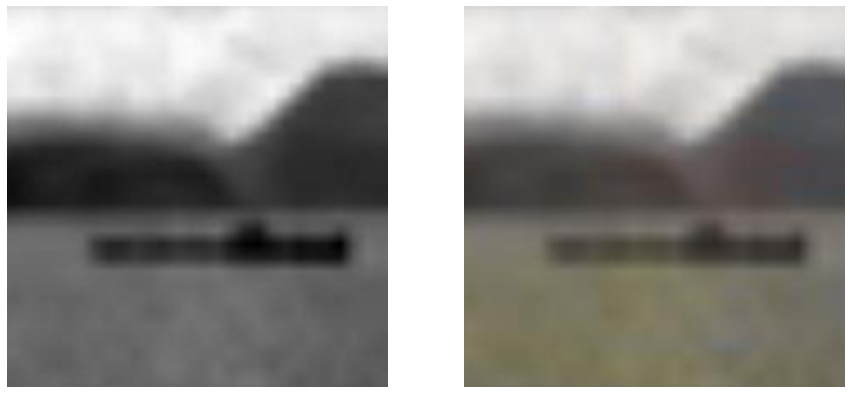

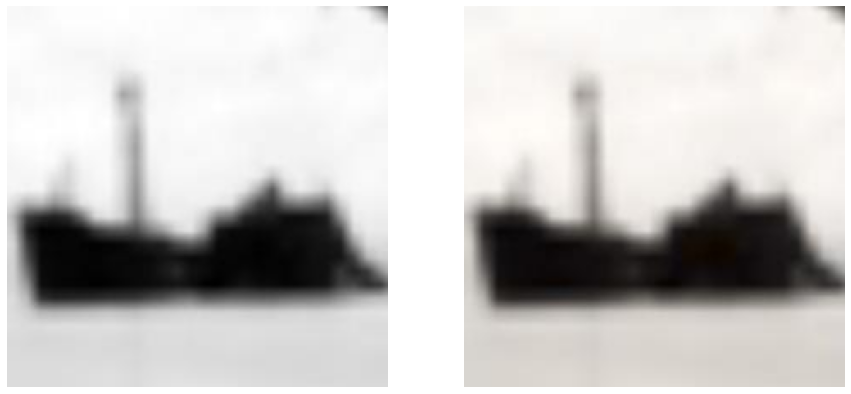

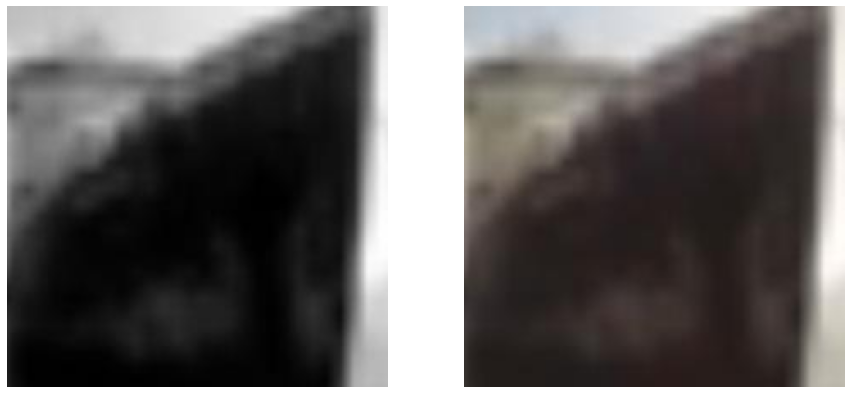

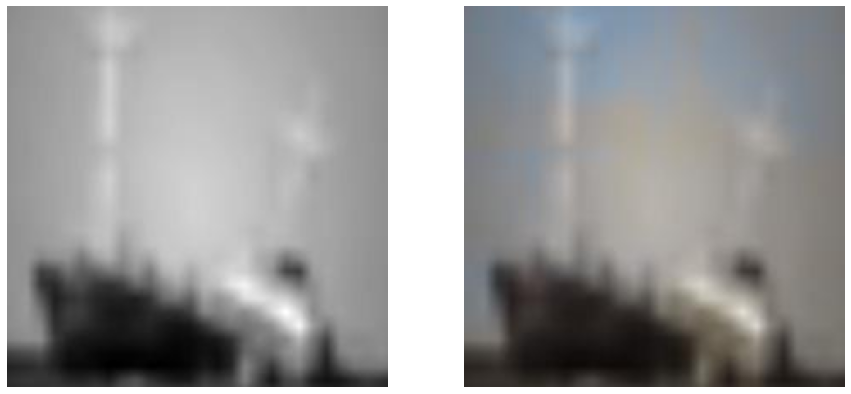

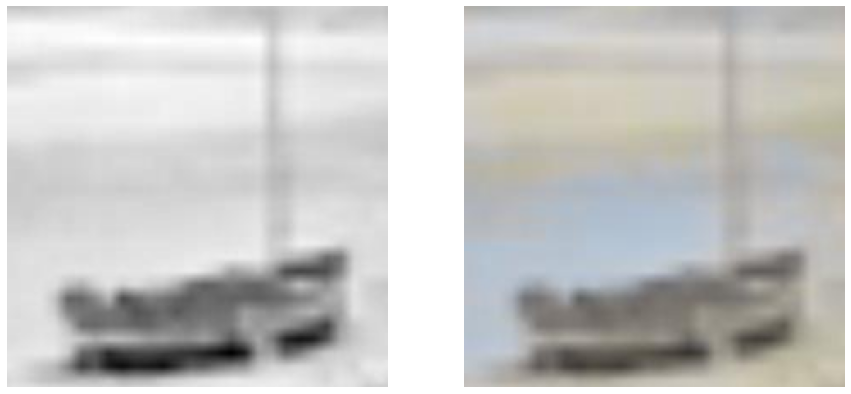

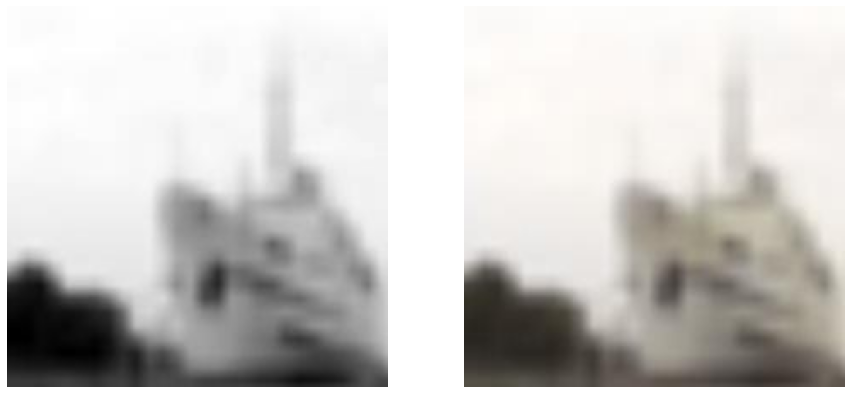

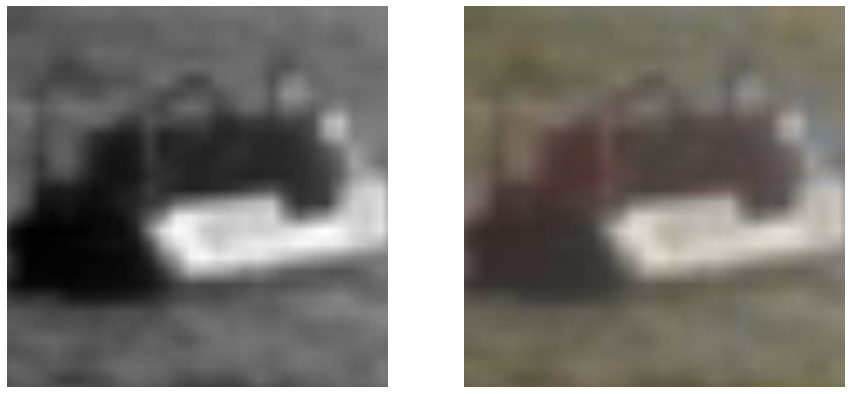

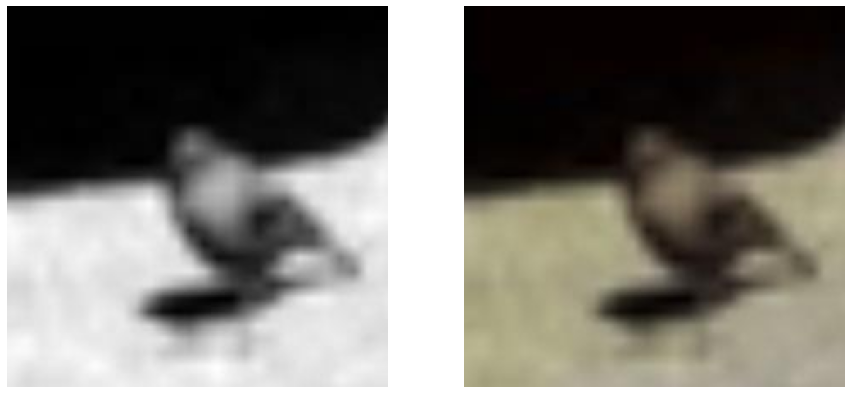

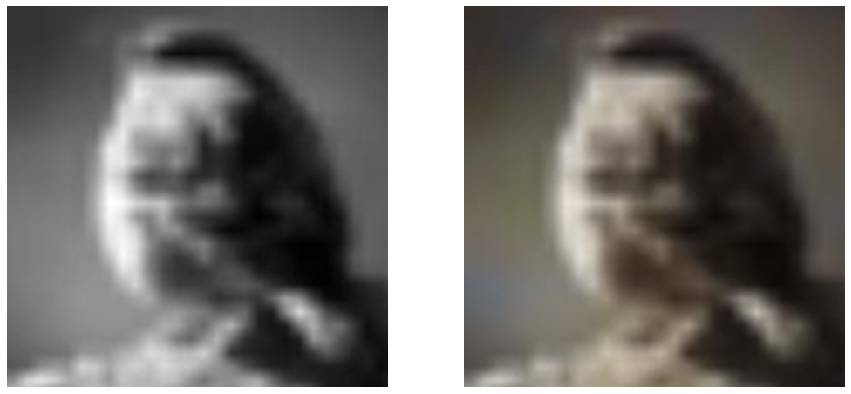

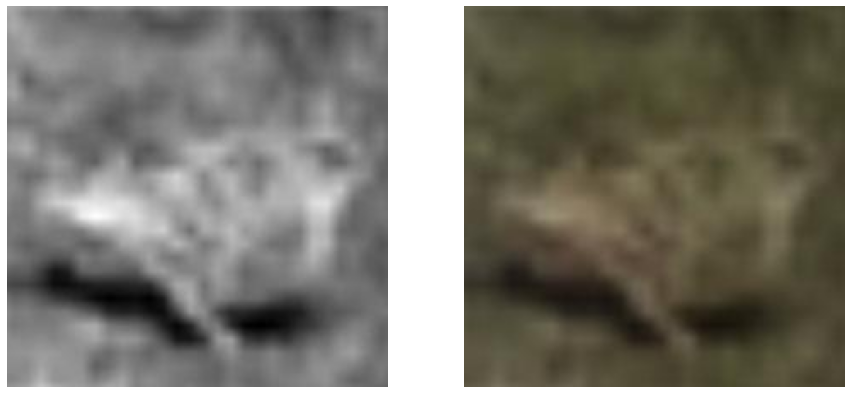

In [22]:
# Show images 
image_pairs = []

for i in range(10):
    image_pairs.append((f'{color_imgs}img-{i}-epoch-{best_epoch}.jpg', f'{gray_imgs}img-{i}-epoch-{best_epoch}.jpg'))
    
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()